# Librerias

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Clasificación Multiclase 

## Modelo EfficientNetB0

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB0-dataBalanceada')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar y configurar el modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


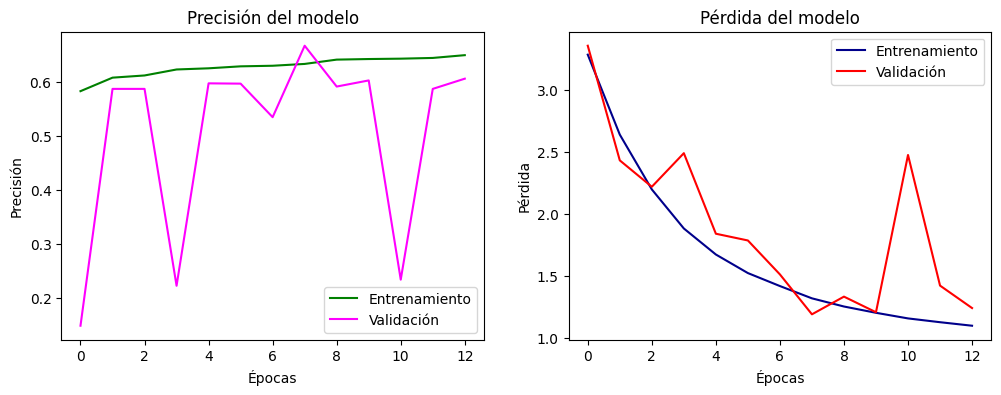

In [ ]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()


# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB4

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB4-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


NameError: name 'history' is not defined

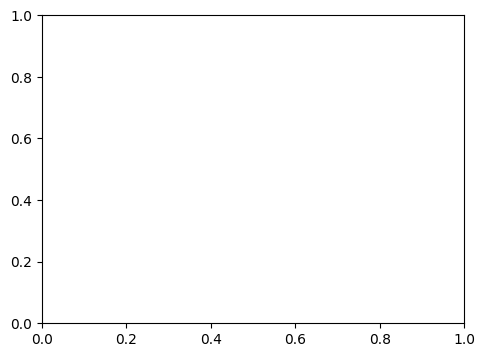

In [7]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB5

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='EfficientNetB5')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


NameError: name 'history' is not defined

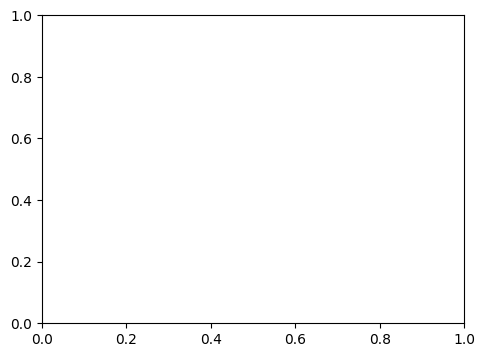

In [8]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV2

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV2')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


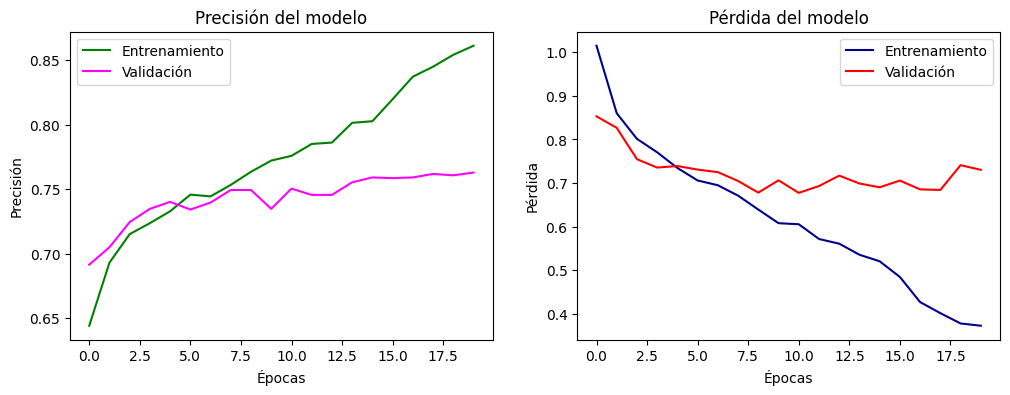

In [144]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV3

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

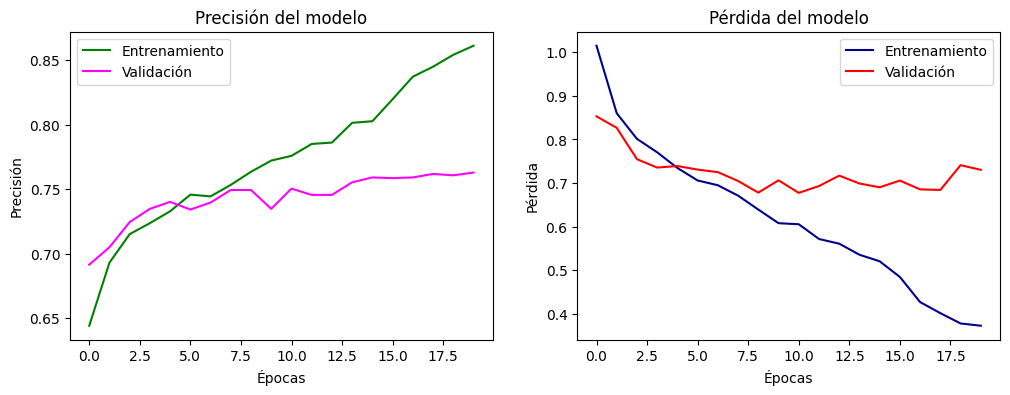

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo InceptionV3

In [8]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='InceptionV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # InceptionV3 requiere imágenes de 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_inception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


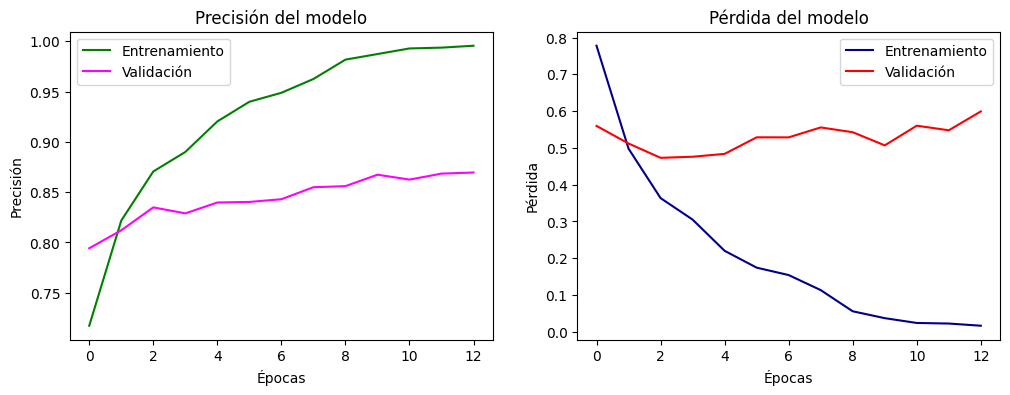

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo Xception

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='Xception-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # Xception también requiere 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


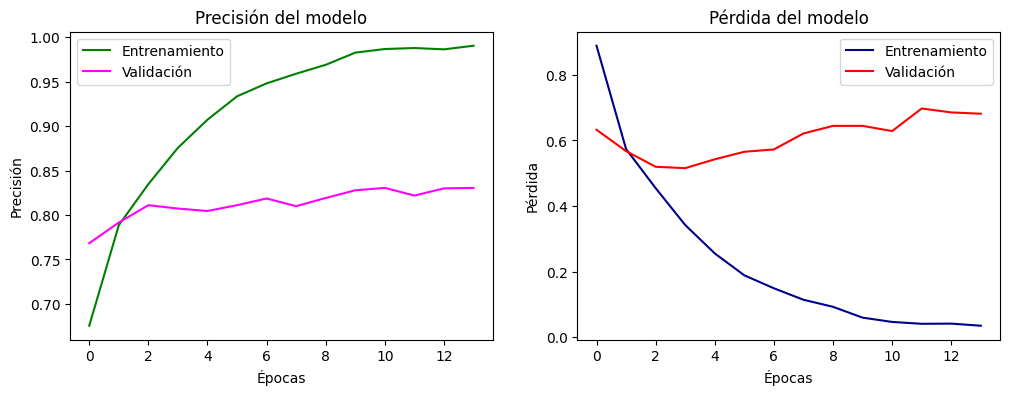

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Clasificación Binaria -> clasificación luego multiclase

## Clasificación Binaria

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2

In [533]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import shutil

# Directorio de las imágenes
data_dir = 'crops_90x90'

# Directorios de salida para las imágenes
output_dir = 'crops_90x90_2clases'  # Directorio base para las nuevas carpetas
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Crear las carpetas si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subcarpetas adicionales para "lesion" y "no lesion"
lesion_subfolders = ['1_lesion', '0_no_lesion']
for subfolder in lesion_subfolders:
    os.makedirs(os.path.join(train_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subfolder), exist_ok=True)

# Configuración del generador de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar todas las imágenes y etiquetas
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',  # Multiclase inicialmente
    classes=['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'],
    shuffle=True
)

# Obtener los nombres de archivos y etiquetas
filepaths = all_images_generator.filepaths
labels = all_images_generator.classes

# Convertir las etiquetas multiclase en binarias basado en el índice de 'Negative'
negative_index = all_images_generator.class_indices['Negative']
has_lesion = np.where(labels == negative_index, 0, 1)  # 0: Negative (sin lesión), 1: Otras clases (con lesión)

# Función para generar un dataframe desde los archivos seleccionados con una columna adicional "has_lesion"
def create_dataframe_with_lesion(files, labels, has_lesion_str):
    df = pd.DataFrame({'filename': files, 'label': labels, 'has_lesion': has_lesion_str})
    return df

# Dividir en entrenamiento (70%), validación (15%) y prueba (15%)
train_files, test_files, train_labels, test_labels, train_lesion, test_lesion = train_test_split(
    filepaths, labels, has_lesion.astype(str), test_size=0.30, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels, val_lesion, test_lesion = train_test_split(
    test_files, test_labels, test_lesion, test_size=0.5, stratify=test_labels, random_state=42
)

# Función para copiar imágenes a las carpetas correspondientes
def copy_images(filepaths, lesions, dest_dir):
    for filepath, lesion in zip(filepaths, lesions):
        if lesion == '0':  # Sin lesión (Negative)
            dest_subfolder = '0_no_lesion'
        else:  # Con lesión (todas las demás clases)
            dest_subfolder = '1_lesion'
        
        # Obtener el nombre de la subcarpeta (lesion/no lesion)
        dest_path = os.path.join(dest_dir, dest_subfolder)
        shutil.copy(filepath, dest_path)  # Copiar la imagen

# Copiar imágenes a las carpetas correspondientes en función de si tienen lesión o no
copy_images(train_files, train_lesion, train_dir)
copy_images(val_files, val_lesion, val_dir)
copy_images(test_files, test_lesion, test_dir)

# Imprimir el resultado
print(f"Total de imágenes copiadas a entrenamiento: {len(train_files)}")
print(f"Total de imágenes copiadas a validación: {len(val_files)}")
print(f"Total de imágenes copiadas a prueba: {len(test_files)}")

Found 11534 images belonging to 6 classes.
Total de imágenes copiadas a entrenamiento: 8073
Total de imágenes copiadas a validación: 1730
Total de imágenes copiadas a prueba: 1731


In [529]:
print(all_images_generator.class_indices)

{'Negative': 0, 'HSIL': 1, 'LSIL': 2, 'ASC-H': 3, 'ASC-US': 4, 'SCC': 5}


In [432]:
# Directorios de las carpetas
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde los directorios con la estructura de carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(90, 90),
    batch_size=64,
    class_mode='binary'  # Clasificación binaria
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(90, 90),
    batch_size=64,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=64,
    class_mode='binary'
)

Found 8073 images belonging to 2 classes.
Found 1730 images belonging to 2 classes.
Found 1731 images belonging to 2 classes.


Etiquetas de entrenamiento: {'lesion': 0, 'no lesion': 1}
Total de imágenes en el entrenamiento: 8073
Etiquetas de validación: {'lesion': 0, 'no lesion': 1}
Total de imágenes en la validación: 1730
Etiquetas de prueba: {'lesion': 0, 'no lesion': 1}
Total de imágenes en la prueba: 1731


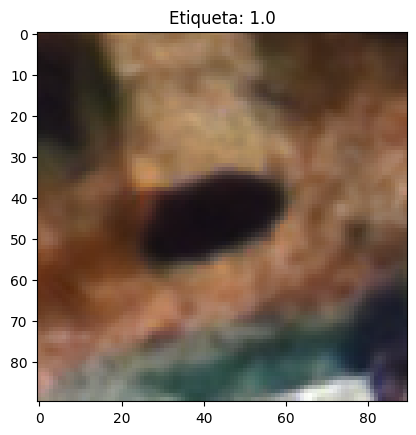

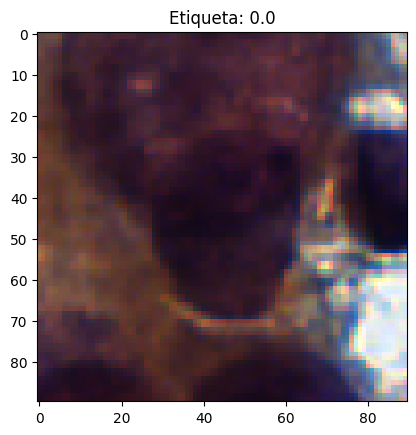

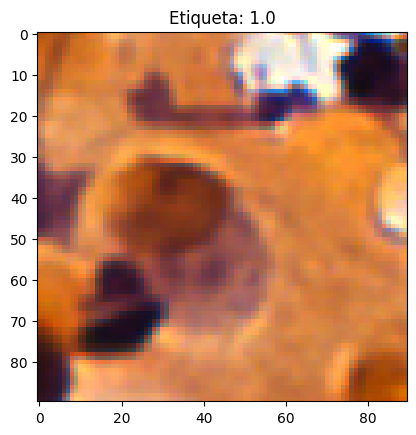

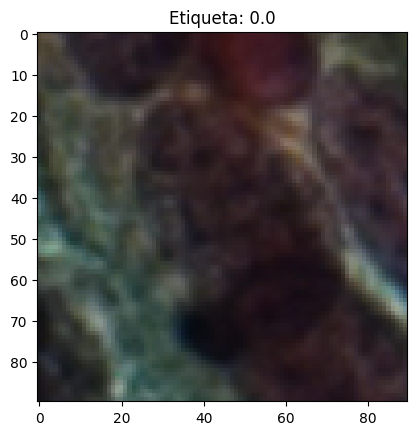

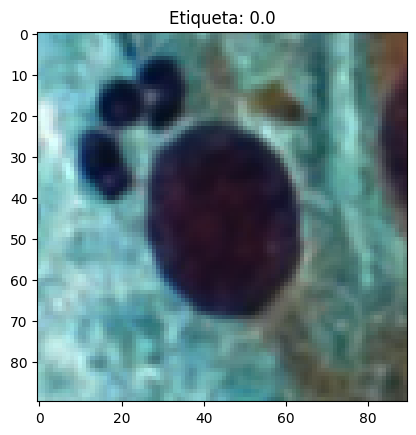

In [510]:
# Verificar las clases en el conjunto de entrenamiento
print("Etiquetas de entrenamiento:", train_generator.class_indices)
print("Total de imágenes en el entrenamiento:", train_generator.samples)

# Verificar las clases en el conjunto de validación
print("Etiquetas de validación:", val_generator.class_indices)
print("Total de imágenes en la validación:", val_generator.samples)

# Verificar las clases en el conjunto de prueba
print("Etiquetas de prueba:", test_generator.class_indices)
print("Total de imágenes en la prueba:", test_generator.samples)

import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes y etiquetas
images, labels = next(train_generator)

# Mostrar algunas imágenes y sus etiquetas
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Etiqueta: {labels[i]}")
    plt.show()

In [514]:
# Obtener las etiquetas verdaderas del generador de prueba
y_true = test_generator.classes

# Imprimir las primeras etiquetas verdaderas
print(f"Etiquetas verdaderas: {y_true[:10]}")


# Obtener las probabilidades predichas por el modelo
y_pred_prob = model.predict(test_generator)

# Imprimir las primeras predicciones
print(f"Probabilidades predichas: {y_pred_prob[:10]}")

# Convertir las probabilidades en clases binarias con un umbral de 0.5
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Imprimir las primeras clases predichas
print(f"Clases predichas: {y_pred_class[:10]}")

Etiquetas verdaderas: [0 0 0 0 0 0 0 0 0 0]
28/28 [==============================] - 2s 61ms/step
Probabilidades predichas: [[0.99279684]
 [0.05662872]
 [0.9896773 ]
 [0.98103327]
 [0.36012557]
 [0.99703395]
 [0.9986252 ]
 [0.93892497]
 [0.9977308 ]
 [0.5616972 ]]
Clases predichas: [[1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [517]:
# Verificar el balance de clases en el conjunto de entrenamiento
train_labels = train_generator.classes
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Distribución de clases en entrenamiento: {dict(zip(unique, counts))}")

# Verificar el balance de clases en el conjunto de validación
val_labels = val_generator.classes
unique, counts = np.unique(val_labels, return_counts=True)
print(f"Distribución de clases en validación: {dict(zip(unique, counts))}")

# Verificar el balance de clases en el conjunto de prueba
test_labels = test_generator.classes
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Distribución de clases en prueba: {dict(zip(unique, counts))}")

Distribución de clases en entrenamiento: {0: 3328, 1: 4745}
Distribución de clases en validación: {0: 713, 1: 1017}
Distribución de clases en prueba: {0: 714, 1: 1017}


In [518]:
print(f"Ruta usada por el generador de entrenamiento: {train_generator.directory}")
print(f"Ruta usada por el generador de validación: {val_generator.directory}")
print(f"Ruta usada por el generador de prueba: {test_generator.directory}")

Ruta usada por el generador de entrenamiento: crops_90x90_2clases/train
Ruta usada por el generador de validación: crops_90x90_2clases/val
Ruta usada por el generador de prueba: crops_90x90_2clases/test


In [519]:
print(f"Índices de clases en el generador de entrenamiento: {train_generator.class_indices}")
print(f"Índices de clases en el generador de validación: {val_generator.class_indices}")
print(f"Índices de clases en el generador de prueba: {test_generator.class_indices}")

Índices de clases en el generador de entrenamiento: {'lesion': 0, 'no lesion': 1}
Índices de clases en el generador de validación: {'lesion': 0, 'no lesion': 1}
Índices de clases en el generador de prueba: {'lesion': 0, 'no lesion': 1}


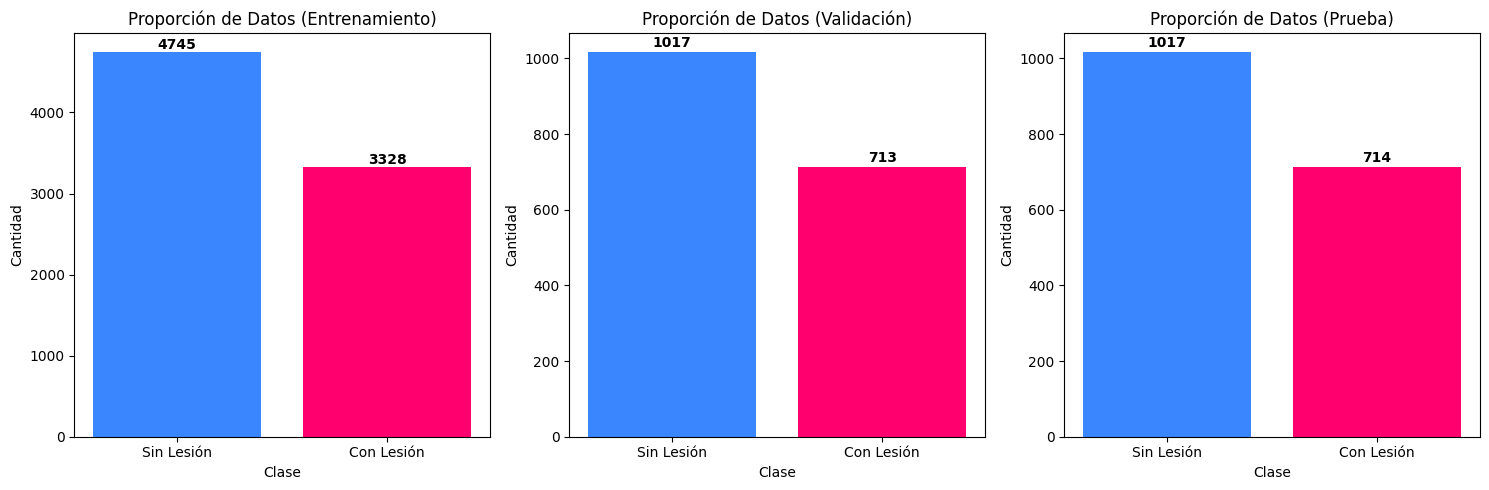

In [516]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Función para contar imágenes en las carpetas "lesion" y "no lesion"
def count_images_in_folders(folder_path):
    lesion_count = len(os.listdir(os.path.join(folder_path, 'lesion')))
    no_lesion_count = len(os.listdir(os.path.join(folder_path, 'no lesion')))
    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

### MovileNetV2

In [486]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(90, 90, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Definir la función de Recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Definir la función de Precisión
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Definir la función F1-Score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])  # Añadimos F1-Score a las métricas

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=10,
    validation_data=val_generator,  # Generador para los datos de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Pasos por época
    validation_steps=val_generator.samples // val_generator.batch_size,  # Pasos de validación
    class_weight={0: 1., 1: 3.5}  # Opcional: Ajustar class_weight para balancear clases
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'Accuracy en el conjunto de prueba: {test_accuracy}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

Epoch 1/10
126/126 [==============================] - 15s 107ms/step - loss: 1.0909 - accuracy: 0.6142 - precision_m: 0.6137 - recall_m: 0.9086 - f1_m: 0.7292 - val_loss: 1.7842 - val_accuracy: 0.5966 - val_precision_m: 0.5936 - val_recall_m: 0.9970 - val_f1_m: 0.7417
Epoch 2/10
126/126 [==============================] - 13s 102ms/step - loss: 0.7823 - accuracy: 0.6965 - precision_m: 0.6657 - recall_m: 0.9733 - f1_m: 0.7875 - val_loss: 1.5812 - val_accuracy: 0.6013 - val_precision_m: 0.5962 - val_recall_m: 0.9961 - val_f1_m: 0.7448
Epoch 3/10
126/126 [==============================] - 13s 100ms/step - loss: 0.6758 - accuracy: 0.7527 - precision_m: 0.7139 - recall_m: 0.9740 - f1_m: 0.8210 - val_loss: 1.2708 - val_accuracy: 0.6134 - val_precision_m: 0.6038 - val_recall_m: 0.9961 - val_f1_m: 0.7490
Epoch 4/10
126/126 [==============================] - 13s 99ms/step - loss: 0.6007 - accuracy: 0.7934 - precision_m: 0.7525 - recall_m: 0.9755 - f1_m: 0.8471 - val_loss: 1.0062 - val_accuracy: 

#### Evaluación

In [488]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
    steps=test_generator.samples // test_generator.batch_size  # Pasos de evaluación
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

27/27 [==============================] - 2s 63ms/step - loss: 0.4350 - accuracy: 0.8102 - precision_m: 0.7740 - recall_m: 0.9557 - f1_m: 0.8539
Pérdida en el conjunto de prueba: 0.43499159812927246
accuracy en el conjunto de prueba: 0.8101851940155029
Precision en el conjunto de prueba: 0.7740045189857483
Recall en el conjunto de prueba: 0.9557469487190247
F1-Score en el conjunto de prueba: 0.8539265394210815


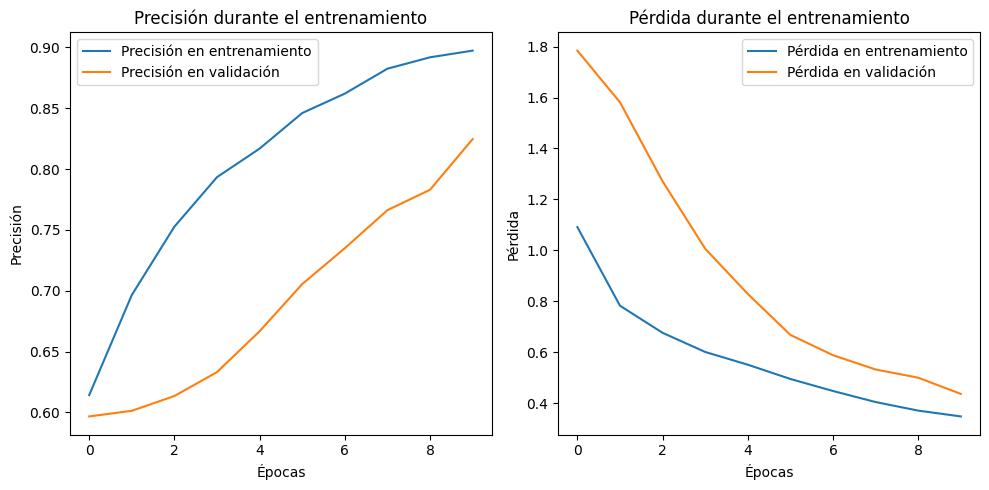

In [489]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

28/28 [==============================] - 2s 59ms/step


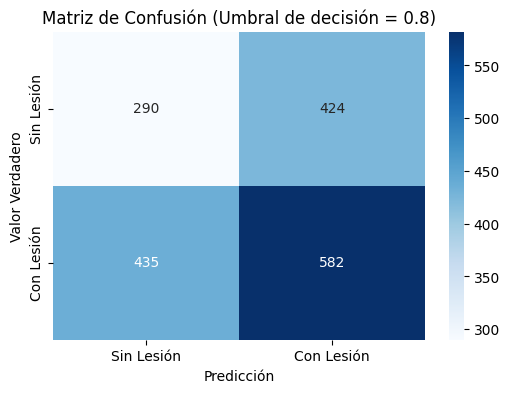

Recall (con umbral = 0.8): 0.5722713864306784
Precisión (con umbral = 0.8): 0.5785288270377733


In [499]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Definir el nuevo umbral de decisión
threshold = 0.8  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

28/28 [==============================] - 2s 61ms/step


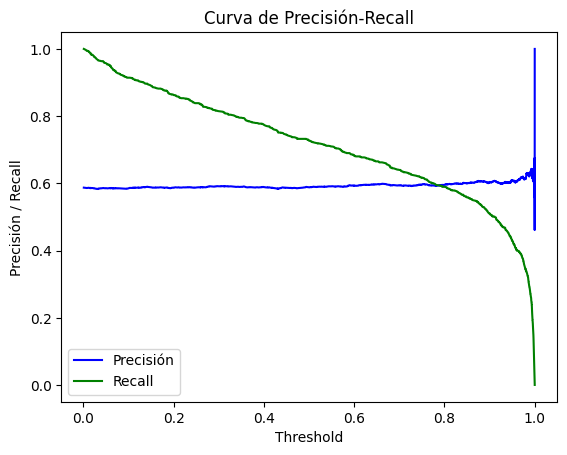

In [495]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

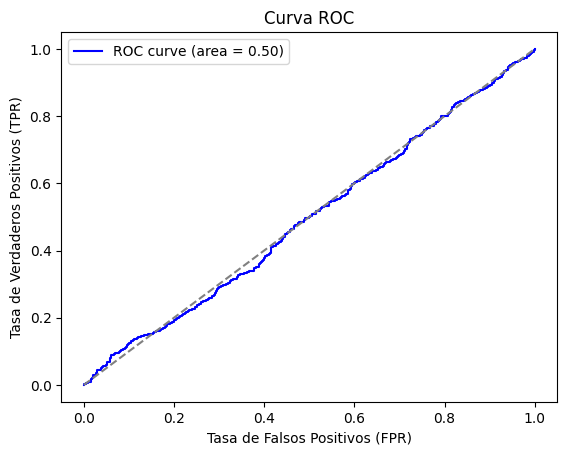

In [492]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [508]:
# Ajustar el umbral de decisión
new_threshold = 0.5
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.5835987261146497
Recall: 0.7207472959685349
F1-Score: 0.6449626044874616
AUC: 0.4883327962453418


In [500]:
# Obtener las probabilidades predichas (no las clases binarias)
y_pred_prob = model.predict(test_generator)

# Generar las etiquetas verdaderas
y_true = test_generator.classes

# Calcular la curva ROC y el AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f'Área bajo la curva ROC: {roc_auc}')

28/28 [==============================] - 2s 62ms/step
Área bajo la curva ROC: 0.4883327962453418


In [493]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

28/28 [==============================] - 2s 61ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.01
Mejor F1-score: 0.739225712198685


### MobileNetV3

In [458]:
from tensorflow.keras.applications import  MobileNetV3Small
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Incrementar el dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])


# Definir la función de Recall y Precisión
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Descongelar algunas capas del modelo base para ajustar los pesos
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Ajusta el número de capas descongeladas si es necesario
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje más baja
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

# Aplicar class_weight para manejar el desbalanceo de clases
class_weight = {0: 1., 1: 1.5}  # Dar más peso a la clase con "lesión"

# Entrenar el modelo con class_weight y un número mayor de épocas
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=20,  # Aumentar el número de épocas
    validation_data=val_generator,  # Generador para los datos de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weight  # Aplicar class_weight
)

Epoch 1/20
126/126 [==============================] - 9s 60ms/step - loss: 0.8623 - accuracy: 0.6108 - precision_m: 0.6301 - recall_m: 0.8234 - val_loss: 0.6795 - val_accuracy: 0.5880 - val_precision_m: 0.5880 - val_recall_m: 1.0000
Epoch 2/20
126/126 [==============================] - 5s 40ms/step - loss: 0.7316 - accuracy: 0.6750 - precision_m: 0.6830 - recall_m: 0.8426 - val_loss: 0.6794 - val_accuracy: 0.5880 - val_precision_m: 0.5880 - val_recall_m: 1.0000
Epoch 3/20
126/126 [==============================] - 5s 41ms/step - loss: 0.6820 - accuracy: 0.6987 - precision_m: 0.7039 - recall_m: 0.8422 - val_loss: 0.6789 - val_accuracy: 0.5880 - val_precision_m: 0.5880 - val_recall_m: 1.0000
Epoch 4/20
126/126 [==============================] - 5s 41ms/step - loss: 0.6472 - accuracy: 0.7226 - precision_m: 0.7256 - recall_m: 0.8560 - val_loss: 0.6796 - val_accuracy: 0.5880 - val_precision_m: 0.5880 - val_recall_m: 1.0000
Epoch 5/20
126/126 [==============================] - 5s 42ms/step -

#### Evaluación

In [459]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
    steps=test_generator.samples // test_generator.batch_size  # Pasos de evaluación
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')

27/27 [==============================] - 1s 47ms/step - loss: 0.7021 - accuracy: 0.5880 - precision_m: 0.5880 - recall_m: 1.0000
Pérdida en el conjunto de prueba: 0.7020612359046936
accuracy en el conjunto de prueba: 0.5879629850387573
Precision en el conjunto de prueba: 0.5879629850387573
Recall en el conjunto de prueba: 1.0


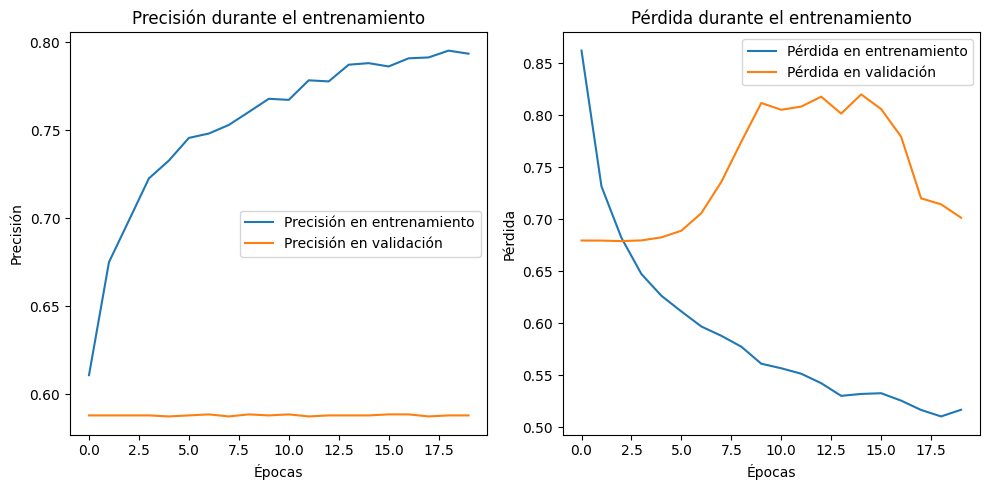

In [460]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

28/28 [==============================] - 1s 38ms/step


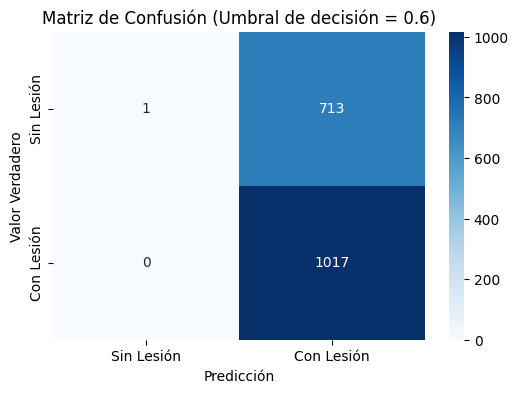

Recall (con umbral = 0.6): 1.0
Precisión (con umbral = 0.6): 0.5878612716763005


In [473]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Definir el nuevo umbral de decisión
threshold = 0.6  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

28/28 [==============================] - 1s 33ms/step


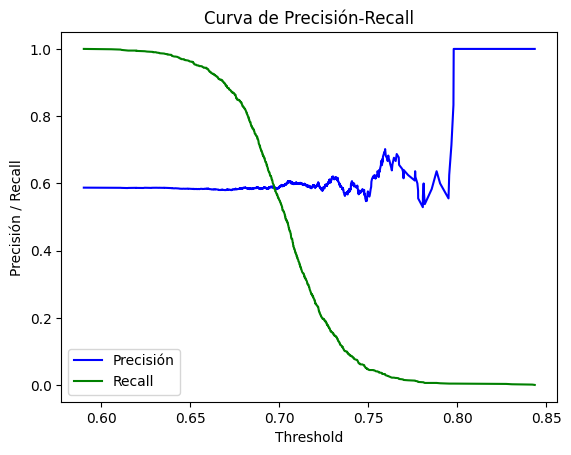

In [474]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

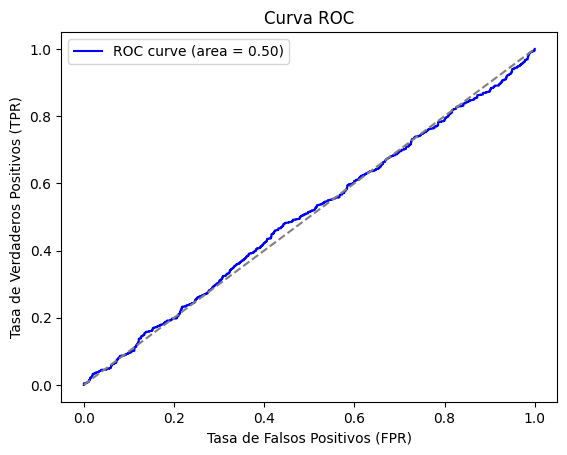

In [475]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [467]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

28/28 [==============================] - 1s 46ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.6
Mejor F1-score: 0.7397160538769568


### ResNet

In [476]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

# Cargar ResNet50 preentrenado en ImageNet, sin la capa superior
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),  # Incrementar el dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])


# Definir la función de Recall y Precisión
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Descongelar algunas capas del modelo base para ajustar los pesos
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Ajusta el número de capas descongeladas si es necesario
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje más baja
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

# Aplicar class_weight para manejar el desbalanceo de clases
class_weight = {0: 1., 1: 3.5}  # Dar más peso a la clase con "lesión"

# Entrenar el modelo con class_weight y un número mayor de épocas
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,  # Aumentar el número de épocas
    validation_data=val_generator,  # Generador para los datos de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weight  # Aplicar class_weight
)

Epoch 1/30
126/126 [==============================] - 87s 675ms/step - loss: 0.9156 - accuracy: 0.6449 - precision_m: 0.6323 - recall_m: 0.9628 - val_loss: 0.7042 - val_accuracy: 0.4196 - val_precision_m: 0.5511 - val_recall_m: 0.0612
Epoch 2/30
126/126 [==============================] - 85s 673ms/step - loss: 0.7662 - accuracy: 0.7249 - precision_m: 0.6889 - recall_m: 0.9650 - val_loss: 0.5707 - val_accuracy: 0.6551 - val_precision_m: 0.6331 - val_recall_m: 0.9841
Epoch 3/30
126/126 [==============================] - 91s 724ms/step - loss: 0.7258 - accuracy: 0.7479 - precision_m: 0.7139 - recall_m: 0.9628 - val_loss: 0.4678 - val_accuracy: 0.7772 - val_precision_m: 0.7521 - val_recall_m: 0.9294
Epoch 4/30
126/126 [==============================] - 107s 847ms/step - loss: 0.6909 - accuracy: 0.7640 - precision_m: 0.7277 - recall_m: 0.9620 - val_loss: 0.4519 - val_accuracy: 0.7760 - val_precision_m: 0.7405 - val_recall_m: 0.9540
Epoch 5/30
126/126 [==============================] - 90s 7

#### Evaluación

In [477]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
    steps=test_generator.samples // test_generator.batch_size  # Pasos de evaluación
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')

27/27 [==============================] - 9s 337ms/step - loss: 0.4376 - accuracy: 0.8270 - precision_m: 0.8431 - recall_m: 0.8671
Pérdida en el conjunto de prueba: 0.43759188055992126
accuracy en el conjunto de prueba: 0.8269675970077515
Precision en el conjunto de prueba: 0.8430753350257874
Recall en el conjunto de prueba: 0.86705082654953


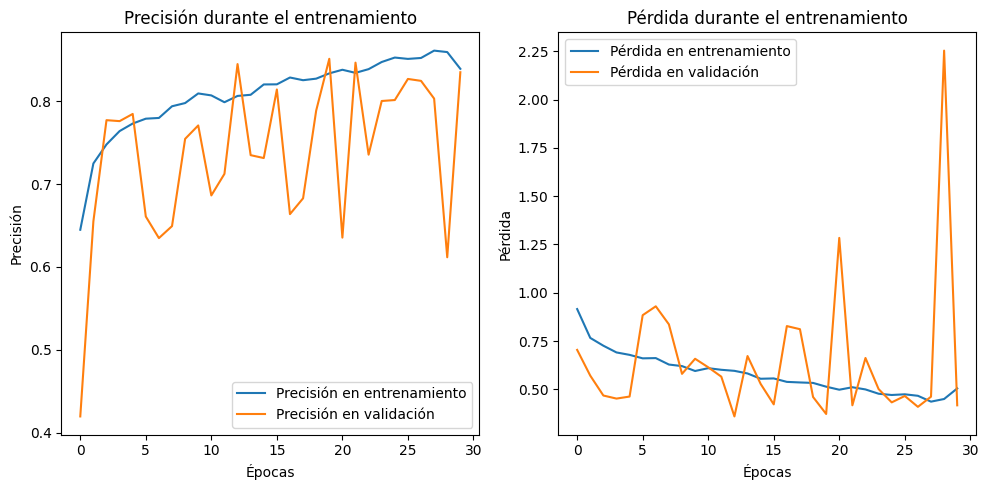

In [483]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

28/28 [==============================] - 9s 306ms/step


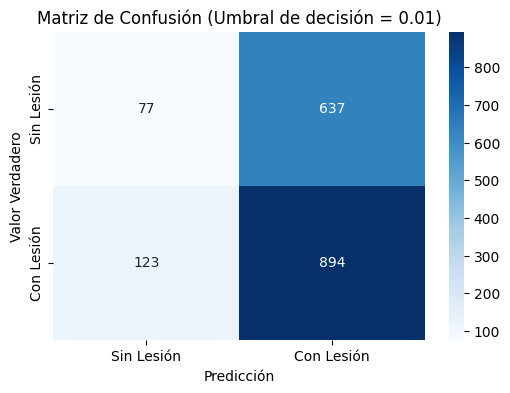

Recall (con umbral = 0.01): 0.8790560471976401
Precisión (con umbral = 0.01): 0.5839320705421294


In [485]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Definir el nuevo umbral de decisión
threshold = 0.01  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

28/28 [==============================] - 10s 347ms/step


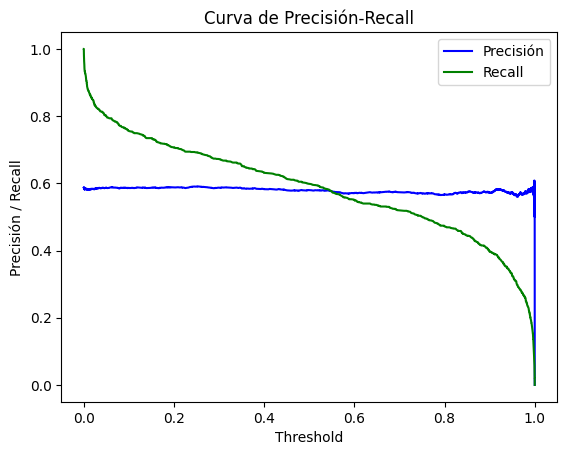

In [480]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

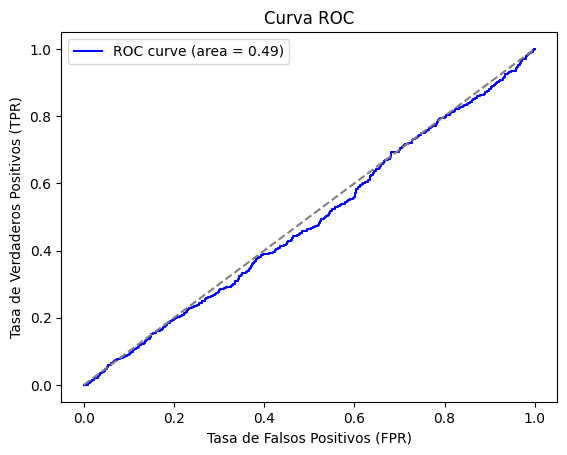

In [481]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [482]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

28/28 [==============================] - 10s 357ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.01
Mejor F1-score: 0.717425431711146


### EfficientNetB0

In [206]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.legacy import RMSprop

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu'),  # Reducimos la cantidad de neuronas para evitar sobreajuste
    layers.Dropout(0.3),  # Mantener Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Definir la función de Recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Definir la función de Precisión
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Mantener congeladas todas las capas menos las últimas 10

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Compilar el modelo con una tasa de aprendizaje inicial más alta
model.compile(optimizer=Adam(learning_rate=1e-3),  # Tasa de aprendizaje inicial
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

# Entrenar el modelo con el callback para reducir la tasa de aprendizaje
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr],  # Añadir el callback para ajustar la tasa de aprendizaje
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/20
252/252 [==============================] - 115s 443ms/step - loss: 0.6842 - accuracy: 0.5816 - precision_m: 0.1190 - recall_m: 0.0467 - val_loss: 0.6796 - val_accuracy: 0.5874 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0010
Epoch 2/20
252/252 [==============================] - 109s 432ms/step - loss: 0.6800 - accuracy: 0.5874 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6768 - val_accuracy: 0.5885 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0010
Epoch 3/20
252/252 [==============================] - 109s 434ms/step - loss: 0.6790 - accuracy: 0.5879 - precision_m: 0.0040 - recall_m: 2.4802e-04 - val_loss: 0.6780 - val_accuracy: 0.5874 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0010
Epoch 4/20
252/252 [==============================] - 114s 454ms/step - loss: 0.6793 - accuracy: 0.5867 - precision_m: 0.0198 - recall_m: 0.0013 - val_loss: 0.6771 - val_accuracy: 0.5880 - val_precision_m: 0.0000e+00 

KeyboardInterrupt: 

#### Evaluación

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
    steps=test_generator.samples // test_generator.batch_size  # Pasos de evaluación
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')

27/27 [==============================] - 1s 47ms/step - loss: 0.7021 - accuracy: 0.5880 - precision_m: 0.5880 - recall_m: 1.0000
Pérdida en el conjunto de prueba: 0.7020612359046936
accuracy en el conjunto de prueba: 0.5879629850387573
Precision en el conjunto de prueba: 0.5879629850387573
Recall en el conjunto de prueba: 1.0


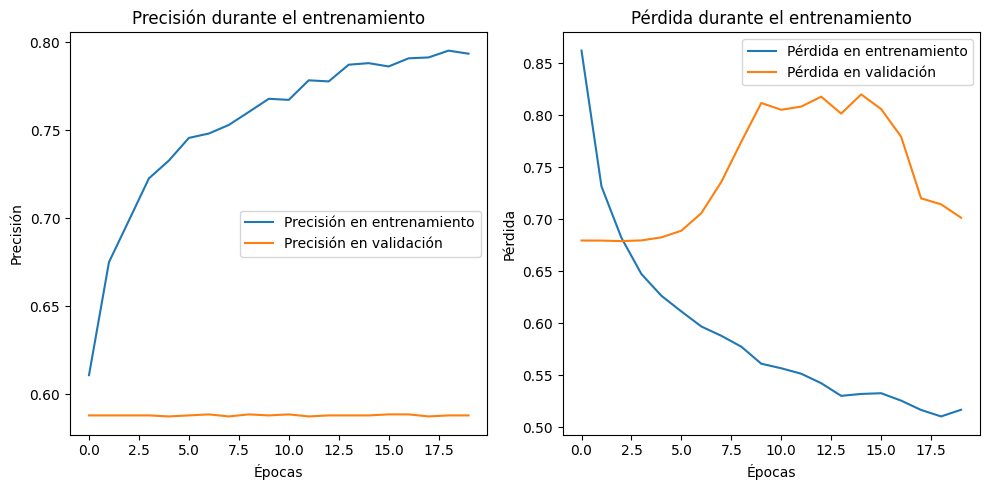

In [ ]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

28/28 [==============================] - 1s 38ms/step


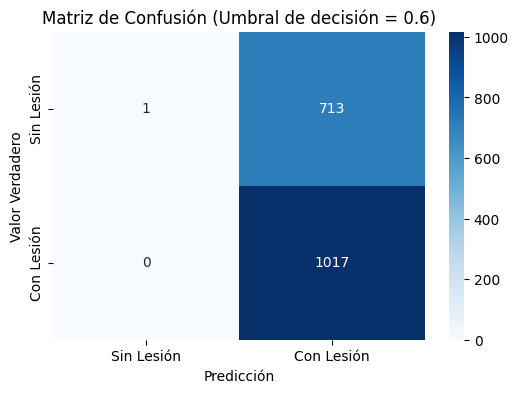

Recall (con umbral = 0.6): 1.0
Precisión (con umbral = 0.6): 0.5878612716763005


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Definir el nuevo umbral de decisión
threshold = 0.6  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

28/28 [==============================] - 1s 33ms/step


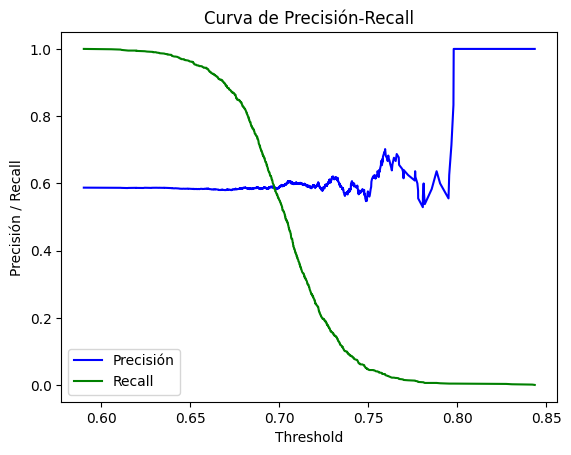

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

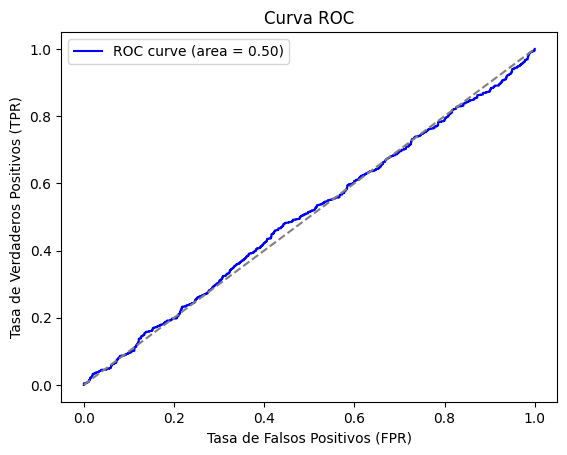

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

28/28 [==============================] - 1s 46ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.6
Mejor F1-score: 0.7397160538769568


### EfficientNetB5

In [418]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cargar EfficientNetB5 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB5(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Descongelar todas las capas del modelo base
base_model.trainable = True

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

# Definir la función de Recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Definir la función de Precisión
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Función para el scheduler del learning rate
def lr_scheduler(epoch, lr):
    decay_rate = 0.96
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# Callbacks para ajustar el learning rate
callbacks = [LearningRateScheduler(lr_scheduler)]

# Compilar el modelo sin class_weight en compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, AUC(name='auc')])

# Ajustar los pesos de clase
class_weights = {0: 1., 1: 1.5}  # Puedes ajustar los valores según el desequilibrio de tu dataset

# Entrenar el modelo usando los generadores de imágenes y pasando class_weight en fit
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=10,
    validation_data=val_generator,  # Generador para los datos de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights  # Aquí es donde se pasa class_weight
)

Found 8073 images belonging to 2 classes.
Found 1730 images belonging to 2 classes.
Found 1731 images belonging to 2 classes.
Epoch 1/10
126/126 [==============================] - 341s 3s/step - loss: 1.0694 - accuracy: 0.8271 - precision_m: 0.8274 - recall_m: 0.8970 - auc: 0.9092 - val_loss: 2.1094 - val_accuracy: 0.4115 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_auc: 0.6552
Epoch 2/10
126/126 [==============================] - 329s 3s/step - loss: 0.7865 - accuracy: 0.9046 - precision_m: 0.8973 - recall_m: 0.9499 - auc: 0.9633 - val_loss: 3.3784 - val_accuracy: 0.4144 - val_precision_m: 0.1852 - val_recall_m: 0.0048 - val_auc: 0.6196
Epoch 3/10
126/126 [==============================] - 324s 3s/step - loss: 0.5805 - accuracy: 0.9348 - precision_m: 0.9290 - recall_m: 0.9652 - auc: 0.9821 - val_loss: 3.0857 - val_accuracy: 0.4120 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_auc: 0.7286
Epoch 4/10
126/126 [==============================] - 311s 2s/s

#### Evaluación

28/28 [==============================] - 14s 445ms/step
Mejor umbral para F1-Score: 0.0
F1-Score con el mejor umbral: 0.7401746724890831


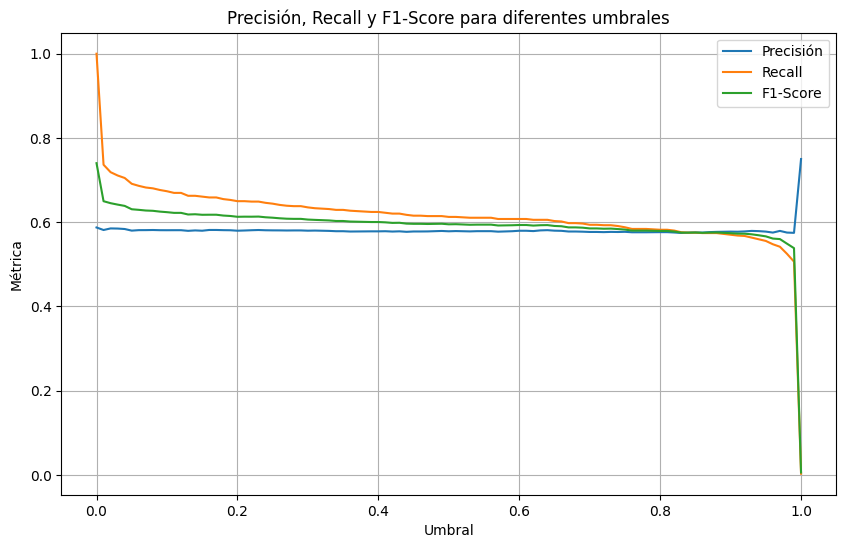

In [419]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Genera las probabilidades para el conjunto de prueba
y_pred_prob = model.predict(test_generator)

# Verdaderos valores (las etiquetas reales)
y_true = test_generator.classes

# Crear arrays para almacenar los resultados
thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []
f1_scores = []

# Evaluar para cada umbral
for threshold in thresholds:
    # Convertir probabilidades a predicciones binarias usando el umbral
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precisión, recall y F1
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))

# Convertir los resultados a arrays para análisis
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

# Encontrar el índice del umbral que maximiza el F1-Score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Mejor umbral para F1-Score: {best_threshold}")
print(f"F1-Score con el mejor umbral: {f1_scores[best_threshold_index]}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisión')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Umbral')
plt.ylabel('Métrica')
plt.title('Precisión, Recall y F1-Score para diferentes umbrales')
plt.legend()
plt.grid(True)
plt.show()

In [420]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
    steps=test_generator.samples // test_generator.batch_size  # Pasos de evaluación
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')


27/27 [==============================] - 12s 447ms/step - loss: 0.7397 - accuracy: 0.8542 - precision_m: 0.8540 - recall_m: 0.9052 - auc: 0.8903
Pérdida en el conjunto de prueba: 0.7397498488426208
accuracy en el conjunto de prueba: 0.8541666865348816
Precision en el conjunto de prueba: 0.8540377020835876
Recall en el conjunto de prueba: 0.9051633477210999
AUC en el conjunto de prueba: 0.8902705311775208


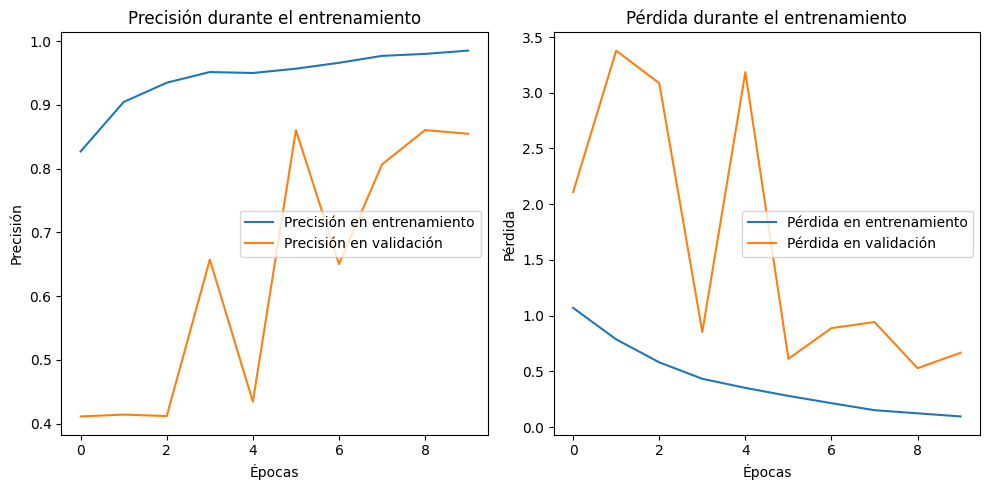

In [421]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

28/28 [==============================] - 13s 467ms/step


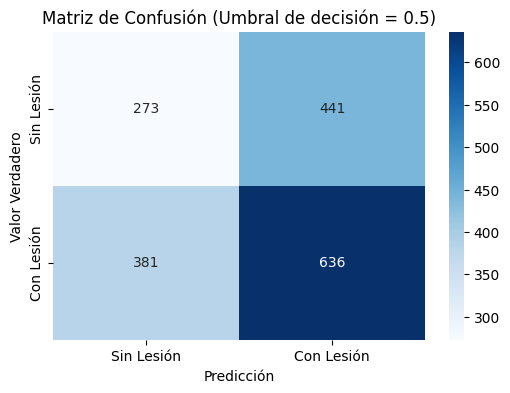

Recall (con umbral = 0.5): 0.6253687315634219
Precisión (con umbral = 0.5): 0.5905292479108635


In [423]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Definir el nuevo umbral de decisión
threshold = 0.5  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

28/28 [==============================] - 12s 434ms/step


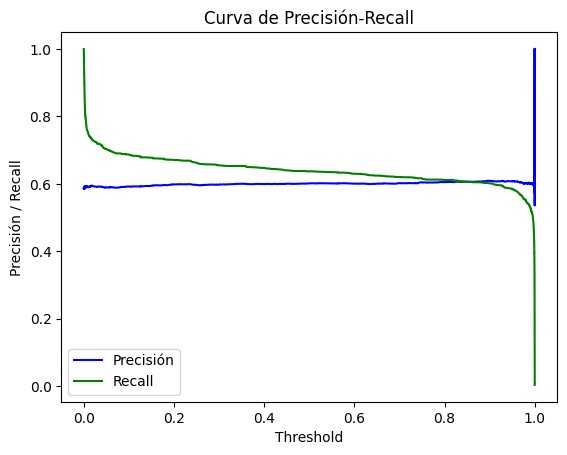

In [424]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

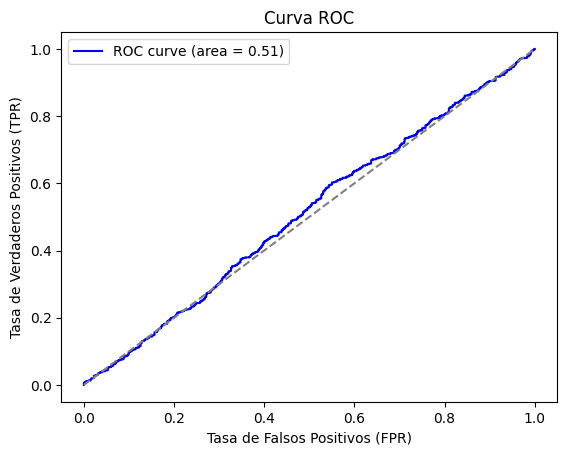

In [426]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [427]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

Mejor threshold para F1-score: 0.0
